# Analysis of iDM Events from LHE

In [1]:
import pylhe
import awkward as ak

## Conversion to Parquet
We first convert the compressed LHE file into a parquet file. The parquet file is about 20% larger, but it offers 2 orders of magnitude speed up when reading the information back into memory. This translation only needs to be done once per LHE file.

In [2]:
def convert_to_parquet(lhe_fp) :
    ak.to_parquet(
        pylhe.to_awkward(
            pylhe.read_lhe(lhe_fp)
        ),
        lhe_fp.replace('lhe.gz','parquet')
    )

In [3]:
convert_to_parquet('../MG5_aMC_v3_4_1/idm-0/Events/run_01/unweighted_events.lhe.gz')

In [5]:
convert_to_parquet('../MG5_aMC_v3_4_1/idm-1-restrict/Events/run_01/unweighted_events.lhe.gz')

## Analysis
Parse in the awkward array with `ak.from_parquet` and then begin filling histograms.

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import mplhep
plt.style.use(mplhep.style.ROOT)

import numpy as np

In [24]:
import hist

In [7]:
opts = [
    ('no restriction', ak.unzip(ak.from_parquet('../MG5_aMC_v3_4_1/idm-0/Events/run_01/unweighted_events.parquet'))),
    ('restriction', ak.unzip(ak.from_parquet('../MG5_aMC_v3_4_1/idm-1-restrict/Events/run_01/unweighted_events.parquet'))),
]

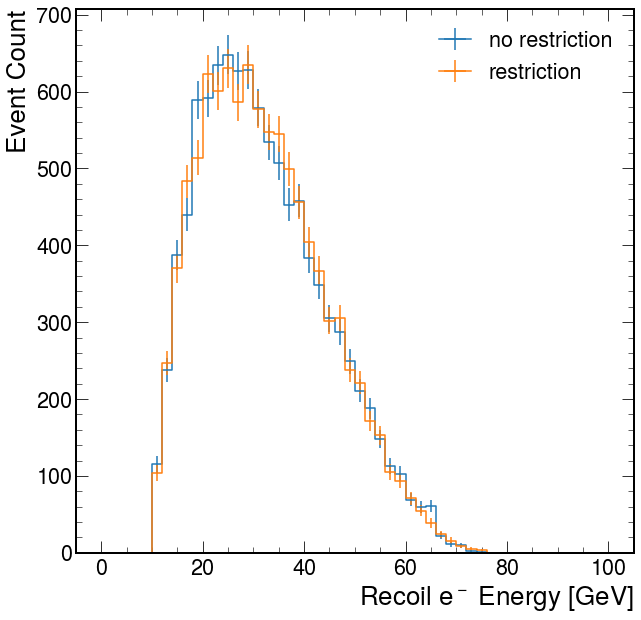

In [31]:
for name, (event_info, particles) in opts :
    h = hist.Hist(hist.axis.Regular(bins=50, start=0, stop=100, name='Recoil Electron Energy [GeV]'))
    h.fill(
        ak.flatten(
            particles[(particles['id']==+11)&(particles['status']==1)&(particles['mother2']==2)]['vector']['t']
        )
    )
    h.plot(label=name)
plt.xlabel('Recoil $e^-$ Energy [GeV]')
plt.ylabel('Event Count')
plt.legend()
plt.show()